In [1]:
import pathlib, copy, re, pickle
from itertools import product
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import matplotlib.ticker as mtick
import seaborn as sns
from Bio import Phylo
from elyawy.constants import SUMSTATS_LIST, SUMSTATS_DEFINITION, length_distributions
from elyawy.sparta import Msa

In [2]:
def get_total_accuracy(datasets: list[str], path: pathlib.Path, epsilon: int) -> pd.DataFrame:
    total_accuracy = []
    for current_data in datasets:
        MAIN_PATH = path / current_data
        print(MAIN_PATH)
        if not MAIN_PATH.exists():
            exit(1)

        for dataset in MAIN_PATH.iterdir():
            current_file = dataset / f"simulation_results_{epsilon}_500000.csv"
            if not current_file.exists():
                # print(dataset.stem)
                continue
            simulation_results_df = pd.read_csv(current_file)
            classification_accuracy = accuracy_score(simulation_results_df["true_dists"],
                                                     simulation_results_df["predicted"])

            total_accuracy.append((classification_accuracy, dataset.stem, current_data))

    accuracy_df = pd.DataFrame(total_accuracy)
    return accuracy_df

In [3]:
# n_i_values = [1, 2, 3, 4, 5, 10, 25, 50, 100, 200, 500, 1000]
n_i_values = [10, 100, 1000]

THRESHOLD = 100

In [4]:
# REMOTE_PATH = '''/run/user/1000/kio-fuse-JIExvn/sftp/elyawygoda@powerlogin.tau.ac.il:22
#                  /groups/pupko/elyawygoda/length_distributions/all_outputs/results'''
REMOTE_PATH = '''/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=
                 elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/results/'''

REMOTE_PATH = re.sub(r"\n\s*", "", REMOTE_PATH)
REMOTE_PATH = pathlib.Path(REMOTE_PATH).resolve()
datasets = ["eggnog", "yeast"]
n_i_accuracy: dict[int: pd.DataFrame] = {}
for n_i in n_i_values:
    n_i_accuracy[n_i] = get_total_accuracy(datasets, REMOTE_PATH, n_i)

/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/results/eggnog
/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/results/yeast
/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/results/eggnog
/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/results/yeast
/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/results/eggnog
/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/results/yeast


In [5]:
accuracy_summary = pd.DataFrame(columns=n_i_accuracy[100].describe().index)
for n_i in n_i_values:
    n_i_accuracy[n_i].columns = ["accuracy", "dataset","database"]
    # n_i_accuracy[n_i].to_csv(f"accuracies/total_accuracy_{n_i}.csv")
    accuracy_stats = n_i_accuracy[n_i].describe().T
    accuracy_summary = pd.concat([accuracy_summary, accuracy_stats])

In [6]:
for key,val in n_i_accuracy.items():
    val["n_i"] = key
n_i_df = pd.concat(n_i_accuracy).reset_index(drop=True)
n_i_df.to_csv("assets/total_accuracies.csv", index=False)

In [7]:
n_i_accuracy[THRESHOLD]

,accuracy,dataset,database,n_i
0,0.980000,Bacillus_1ZARG,eggnog,100
1,0.976667,Bacillus_1ZART,eggnog,100
2,0.990000,Bacillus_1ZAS4,eggnog,100
3,0.990000,Bacillus_1ZAXF,eggnog,100
4,0.986667,Bacillus_1ZAYH,eggnog,100
...,...,...,...,...
478,1.000000,seqal_chrXVI_282140-282664_+_YPL143W,yeast,100
479,0.996667,seqal_chrXVI_377993-378386_-_YPL090C,yeast,100
480,0.990000,seqal_chrXVI_406644-407064_+_YPL079W,yeast,100
481,0.996667,seqal_chrXVI_654165-654567_+_YPR043W,yeast,100


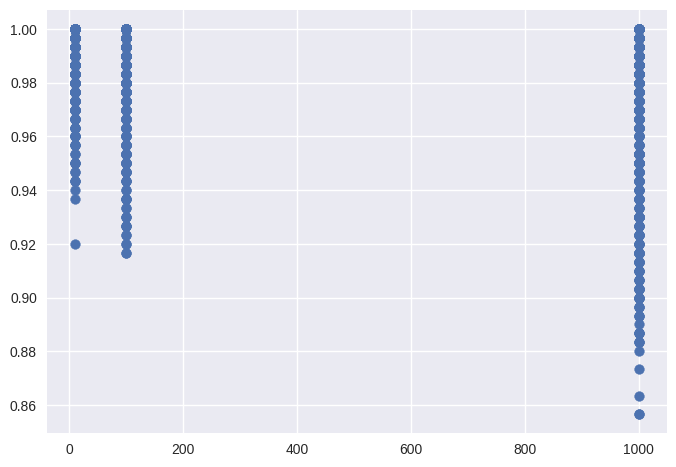

In [8]:
plt.scatter(x=n_i_df.n_i, y=n_i_df.accuracy)

In [9]:
accuracy_summary.index = n_i_values

In [12]:
accuracy_summary

,count,mean,std,min,25%,50%,75%,max
10,483.0,0.990566,0.013320,0.920000,0.986667,0.996667,1.00,1.0
100,483.0,0.983692,0.019453,0.916667,0.973333,0.993333,1.00,1.0
1000,483.0,0.963520,0.032844,0.856667,0.943333,0.973333,0.99,1.0


<AxesSubplot: >

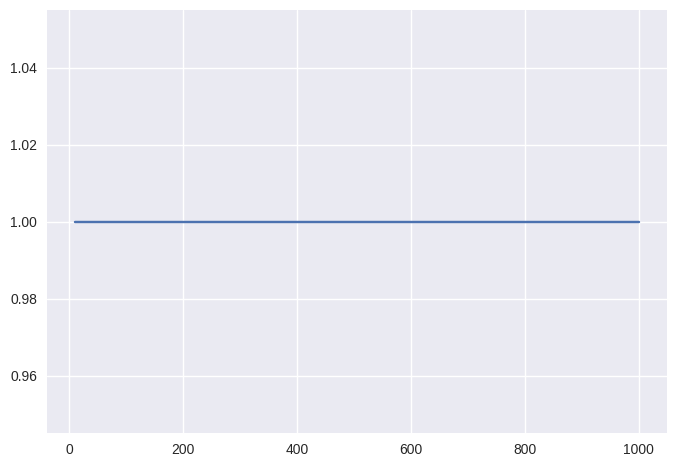

In [11]:
accuracy_summary["min"].plot()

In [13]:
n_i_accuracy[THRESHOLD].describe()

,accuracy,n_i
count,483.000000,483.0
mean,0.983692,100.0
std,0.019453,0.0
min,0.916667,100.0
25%,0.973333,100.0
50%,0.993333,100.0
75%,1.000000,100.0
max,1.000000,100.0


In [14]:
n_i_accuracy[10].accuracy.value_counts(normalize=True)

1.000000    0.428571
0.996667    0.126294
0.990000    0.076605
0.993333    0.076605
0.986667    0.062112
0.983333    0.035197
0.980000    0.031056
0.976667    0.031056
0.970000    0.028986
0.973333    0.026915
0.966667    0.016563
0.960000    0.012422
0.963333    0.010352
0.950000    0.008282
0.956667    0.008282
0.943333    0.006211
0.953333    0.004141
0.946667    0.004141
0.940000    0.002070
0.936667    0.002070
0.920000    0.002070
Name: accuracy, dtype: float64

In [15]:
accuracy_percent = n_i_accuracy[THRESHOLD].accuracy.value_counts()
accuracy_percent[accuracy_percent.index >= 0.99].sum()/len(n_i_accuracy[THRESHOLD])
# accuracy_percent[accuracy_percent.index < 0.9].sum()


0.577639751552795

In [16]:
n_i_accuracy[THRESHOLD]

,accuracy,dataset,database,n_i
0,0.980000,Bacillus_1ZARG,eggnog,100
1,0.976667,Bacillus_1ZART,eggnog,100
2,0.990000,Bacillus_1ZAS4,eggnog,100
3,0.990000,Bacillus_1ZAXF,eggnog,100
4,0.986667,Bacillus_1ZAYH,eggnog,100
...,...,...,...,...
478,1.000000,seqal_chrXVI_282140-282664_+_YPL143W,yeast,100
479,0.996667,seqal_chrXVI_377993-378386_-_YPL090C,yeast,100
480,0.990000,seqal_chrXVI_406644-407064_+_YPL079W,yeast,100
481,0.996667,seqal_chrXVI_654165-654567_+_YPR043W,yeast,100


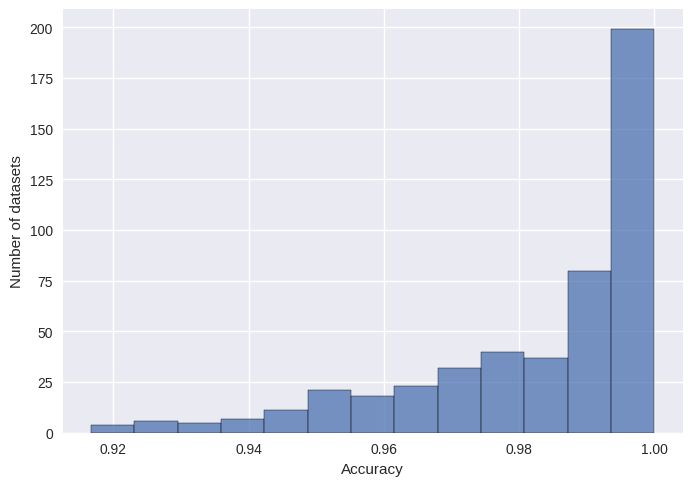

In [17]:
sns.histplot(n_i_accuracy[THRESHOLD],x="accuracy", legend=False)
plt.ylabel("Number of datasets")
plt.xlabel("Accuracy")
plt.savefig("assets/total_accuracy.png", dpi=200)
plt.show()

In [28]:
n_i_accuracy[THRESHOLD].accuracy.mean()

0.9836922015182885

In [29]:
n_i_accuracy[THRESHOLD].accuracy.min()

0.9166666666666666